In [2]:
#import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#import preprocessing/modeling/error metric packages
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit


In [3]:
combined_avg = pd.read_csv('../raw_data/combined_avg.csv', index_col='time', parse_dates=True)

In [4]:
combined_avg.head(2)

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,price day ahead,price actual,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,50.1,65.41,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,48.1,64.92,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0


In [5]:
combined_avg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35018 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35018 non-null  float64
 1   generation fossil brown coal/lignite         35018 non-null  float64
 2   generation fossil gas                        35018 non-null  float64
 3   generation fossil hard coal                  35018 non-null  float64
 4   generation fossil oil                        35018 non-null  float64
 5   generation hydro pumped storage consumption  35018 non-null  float64
 6   generation hydro run-of-river and poundage   35018 non-null  float64
 7   generation hydro water reservoir             35018 non-null  float64
 8   generation nuclear                           35018 non-null  float64
 9   generation other         

In [6]:
#function to make train-test split for time-indexed data
def ts_train_test(data, target_col_name = 'total load actual', test_size=0.15, stdzd=False, cols_to_scale=None):
    df = data.copy()
    test_index = int(len(df)*(1-test_size)) #get index where test set begins
        
    X_train = df.drop([target_col_name,'total load forecast'], axis = 1).iloc[:test_index]
    y_train = df[target_col_name].iloc[:test_index]
    X_test = df.drop([target_col_name,'total load forecast'], axis = 1).iloc[test_index:]
    y_test = df[target_col_name].iloc[test_index:]
    
    # StandardScaler fit seperately on training and test sets
    if stdzd == True:
        scaler = StandardScaler()
        X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
        X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
    
    return X_train, X_test, y_train, y_test        

In [37]:
#Let's engineer some categorical features for use in a regression model like weekend/weekday, winter/summer/spring-fall
df_features = combined_avg.iloc[:,16:].drop(['price day ahead', 'price actual'], axis=1)
df_features.head()

,total load forecast,total load actual,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all
time,,,,,,,,,,
2014-12-31 23:00:00+00:00,26118.0,25385.0,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0
2015-01-01 00:00:00+00:00,24934.0,24382.0,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0
2015-01-01 01:00:00+00:00,23515.0,22734.0,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0
2015-01-01 02:00:00+00:00,22642.0,21286.0,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0
2015-01-01 03:00:00+00:00,21785.0,20264.0,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0


In [8]:
#function to calculate basic season label based on month
def season_determination(month):
    if month in [6,7,8,9]: #June-Sept = summer (highest need for cooling in Spain)
        return "summer"
    elif month in [1,2,12]: #Dec, Jan, Feb = winter (highest need for heating)
        return "winter"
    else:
        return "spring/fall" #all other months are spring or fall (similar lower needs for heating/cooling)

In [38]:
day_of_week = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}
df_features['hour'] = df_features.index.hour
df_features['weekday'] = df_features.index.weekday.map(day_of_week)
df_features['month'] = df_features.index.month #have to create month column because cannot apply() on datetimeindex
df_features['season'] = df_features.month.apply(season_determination)
df_features['nonwork-work_day'] = np.where(df_features.index.weekday > 5, 0, 1)
display(df_features.shape, df_features.head());

(35018, 15)

,total load forecast,total load actual,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all,hour,weekday,month,season,nonwork-work_day
time,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,26118.0,25385.0,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,23,Wednesday,12,winter,1
2015-01-01 00:00:00+00:00,24934.0,24382.0,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0,Thursday,1,winter,1
2015-01-01 01:00:00+00:00,23515.0,22734.0,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,1,Thursday,1,winter,1
2015-01-01 02:00:00+00:00,22642.0,21286.0,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0,2,Thursday,1,winter,1
2015-01-01 03:00:00+00:00,21785.0,20264.0,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0,3,Thursday,1,winter,1


In [39]:
df_features.drop("month", axis=1, inplace=True)

Now that I've used the weekday and month to create the type_of_day and season columns, 
I need to drop the month column because the test set may not contain all months. Now time to one-hot encode the new categorical variables.

In [40]:
#let's split data and then encode the new catergorical variables
X_train, X_test, y_train, y_test = ts_train_test(data = df_features, stdzd=True, 
                                                 cols_to_scale=['temp','pressure','humidity',
                                                                'wind_speed','rain_1h','snow_3h','clouds_all'])
cat_cols = ['hour','weekday','season']
X_train_cat = X_train[['hour','weekday','season']]
X_test_cat = X_test[['hour','weekday','season']]

encoder = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')

encoder.fit(X_train_cat)
X_train.drop(columns = cat_cols, inplace=True)
X_train_cat = pd.DataFrame(encoder.transform(X_train_cat), index=X_train.index, 
                           columns = encoder.get_feature_names_out()).astype(int)
X_train = X_train.join(X_train_cat, how ='outer')
#X_train.head()
encoder.fit(X_test_cat)
X_test.drop(columns = cat_cols, inplace=True)
X_test_cat = pd.DataFrame(encoder.transform(X_test_cat), index = X_test.index, 
                           columns = encoder.get_feature_names_out()).astype(int)
X_test = X_test.join(X_test_cat, how ='outer')

display(X_train.head(3), X_test.head(3))

,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all,nonwork-work_day,hour_1,...,hour_22,hour_23,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,season_summer,season_winter
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,-2.328428,0.037707,0.980320,-0.349113,135.2,-0.368849,-0.051605,-1.422918,1,0,...,0,1,0,0,0,0,0,1,0,1
2015-01-01 00:00:00+00:00,-2.325480,0.014466,0.980320,-0.349113,135.8,-0.368849,-0.051605,-1.422918,1,0,...,0,0,0,0,0,1,0,0,0,1
2015-01-01 01:00:00+00:00,-2.382889,0.084188,0.953136,-0.063965,119.0,-0.368849,-0.051605,-1.422918,1,1,...,0,0,0,0,0,1,0,0,0,1


,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all,nonwork-work_day,hour_1,...,hour_22,hour_23,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,season_summer,season_winter
time,,,,,,,,,,,,,,,,,,,,,
2018-05-27 00:00:00+00:00,0.010396,-0.217940,1.102647,-0.919408,117.6,-0.368849,-0.051605,0.001720,0,0,...,0,0,0,0,1,0,0,0,0,0
2018-05-27 01:00:00+00:00,-0.018755,-0.241181,1.184198,-0.491687,181.6,-0.368849,-0.051605,0.499765,0,1,...,0,0,0,0,1,0,0,0,0,0
2018-05-27 02:00:00+00:00,-0.060955,-0.334144,1.102647,0.078608,200.0,-0.368849,-0.051605,0.777743,0,0,...,0,0,0,0,1,0,0,0,0,0


So now we have X split into train and test sets, with the first 85% of the data going to training to try to predict approximately the last 7 months out of the four years of data.

In [30]:
#fnc for calculating and presenting error metrics
#error_dict = {} #dict to hold model name and error metrics for various models that are investigated

def error_metrics(y_true, y_pred, model_name = None):
    '''
        function will print RMSE, R2, MAE, MAPE. Assumes y_pred is np array
    '''
    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    R2 = r2_score(y_true, y_pred)
    MAE = mean_absolute_error(y_true, y_pred)
    MAPE = (np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

    print('\nError metrics for {} model'.format(model_name))
    print("RMSE: %.2f" % RMSE)
    print('Variance/R^2: %.2f' % R2)
    print('MAE: %.2f' % MAE)
    print('Mean Absolute Percentage Error: %.2f %%' % MAPE)

In [25]:
#fnc for plotting time series of predicted vs true values
def plot_ts_pred_true(y_pred, y_true, model_name=None):
    fig, ax = plt.subplots(figsize =(15,10))
    ax.plot(y_true.index, y_pred, linestyle='-', linewidth=1, label = 'Model Forecasted Total Load', color = 'blue',alpha = 0.4)
    y_true.plot(linestyle='-', linewidth=1, label = 'Actual Total Load', color = 'red',alpha = 0.4)

    plt.ylabel('Load/Demand (MW)')
    plt.xlabel("Time")
    plt.title("Observed vs model-predicted total load (MWH) using {}".format(model_name))
    plt.legend()
    plt.show()

Let's try out a simple linear regression using the weather and categorical variables:

In [41]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [42]:
error_metrics(linreg.predict(X_train), y_train, model_name = 'simple linear regression (train set)')


Error metrics for simple linear regression (train set) model
RMSE: 2854.38
Variance/R^2: 0.36
MAE: 2199.19
Mean Absolute Percentage Error: 7.63 %


In [43]:
error_metrics(linreg.predict(X_test), y_test, model_name = 'simple linear regression (test set)')


Error metrics for simple linear regression (test set) model
RMSE: 2849.41
Variance/R^2: 0.36
MAE: 2173.15
Mean Absolute Percentage Error: 7.55 %


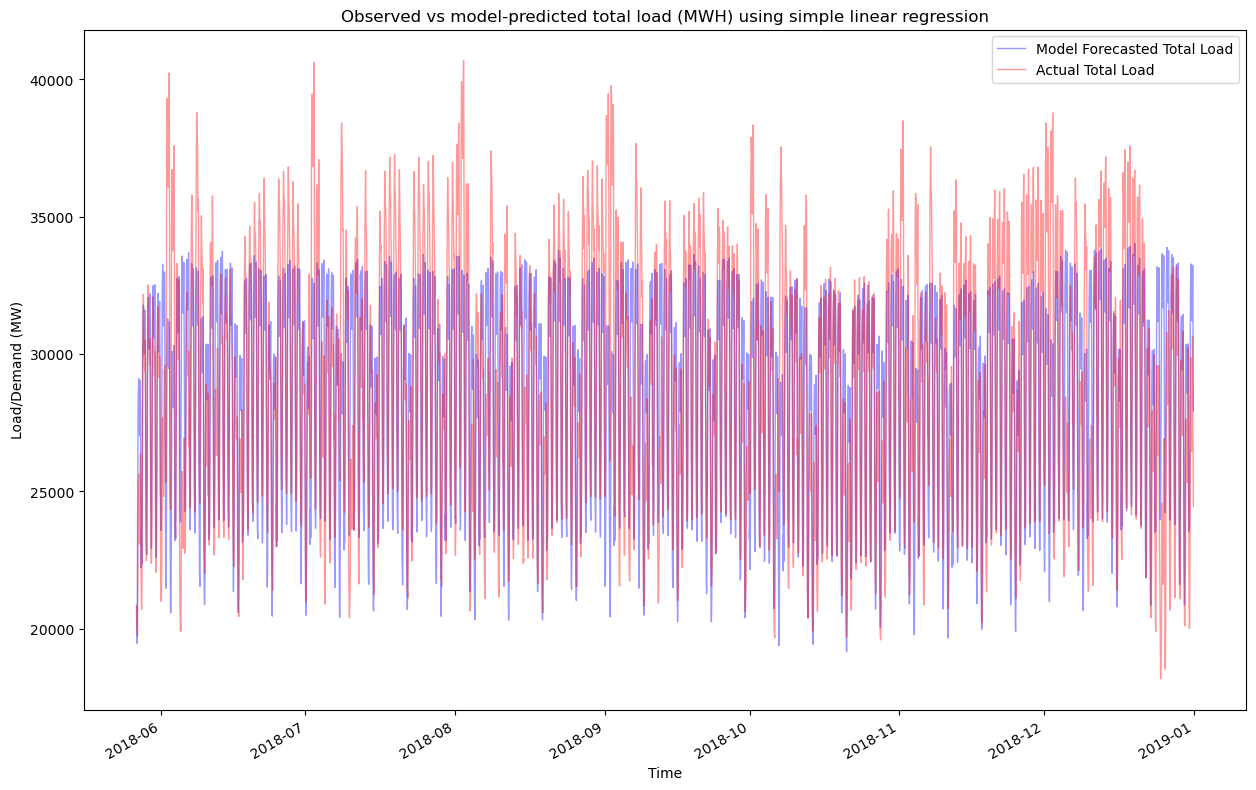

In [44]:
plot_ts_pred_true(y_pred = linreg.predict(X_test), y_true = y_test, model_name = "simple linear regression")

We can see that the simple linear regression model predicts the weekly seasonality fairly well but is often over or underpredicting the max daily load. Let's also check out a baseline model that just predicts the same as the value for the same date/time from the previous year:

In [35]:
# errors metrics for a baseline forecast (that simply repeats the values from the previous year)
error_metrics(df_features.loc[X_test.index.shift(-8760, freq='H'), 'total load actual'], 
                  y_test, model_name='Baseline forecast, repeat of previous year')

KeyError: "[Timestamp('2017-11-14 11:00:00+0000', tz='UTC'), Timestamp('2017-11-14 18:00:00+0000', tz='UTC')] not in index"